<a href="https://colab.research.google.com/github/harikrishnareddymallavarapu/schoolofai/blob/master/Session5_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import pandas as pd
import random
import torch, torchtext
from torchtext.legacy import data 

# Manual Seed
SEED = 43
torch.manual_seed(SEED)

### Loading the datasets

In [ ]:
train = pd.read_excel("stanfordData_train_aug.xlsx")
test = pd.read_excel("stanfordData_test.xlsx")
val = pd.read_excel("stanfordData_val.xlsx")

In [ ]:
train.shape, test.shape, val.shape

((14544, 4), (2210, 2), (1101, 2))

In [ ]:
train.columns, test.columns, val.columns

(Index(['Unnamed: 0', 'index', 'labels', 'sentence'], dtype='object'),
 Index(['labels', 'sentence'], dtype='object'),
 Index(['labels', 'sentence'], dtype='object'))

### Data Loaders creation for train, test and val

In [ ]:
sentence = data.Field(sequential = True, tokenize = 'spacy',lower= True, batch_first =True, include_lengths=True)
Label = data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

In [ ]:
fields = [('sentence', sentence),('labels',Label)]

In [ ]:
train_example = [data.Example.fromlist([train.sentence.iloc[i],train.labels.iloc[i]], fields) for i in range(train.shape[0])] 
test_example = [data.Example.fromlist([test.sentence.iloc[i],test.labels.iloc[i]], fields) for i in range(test.shape[0])] 
val_example = [data.Example.fromlist([val.sentence.iloc[i],val.labels.iloc[i]], fields) for i in range(val.shape[0])] 

In [ ]:
trainDataset = data.Dataset(train_example, fields)
valDataset = data.Dataset(val_example, fields)
testDataset = data.Dataset(test_example, fields)

In [ ]:
(len(trainDataset), len(valDataset), len(testDataset))

(14544, 1101, 2210)

In [ ]:
next(iter(trainDataset)).sentence

['ahe',
 'rock',
 'is',
 'destineo',
 'to',
 'be',
 'the',
 '21st',
 'century',
 "'s",
 'new',
 '`',
 '`',
 'cona',
 ' ',
 "''",
 'and',
 'that',
 'he',
 "'s",
 'going',
 'to',
 'mtke',
 'ansplashneven',
 'greater',
 'than',
 'arndld',
 'schwarzenegger',
 ',',
 'jean',
 '-',
 'claud',
 'va',
 ' ',
 'damme',
 'sr',
 'oteven',
 'segal',
 '.']

### Building Vocabulary

In [ ]:
sentence.build_vocab(trainDataset, vectors="glove.6B.100d")
Label.build_vocab(trainDataset)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.39MB/s]                           
100%|█████████▉| 398609/400000 [00:15<00:00, 24463.08it/s]

In [ ]:
print('Size of input vocab : ', len(sentence.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(sentence.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  29633
Size of label vocab :  5
Top 10 words appreared repeatedly : [('.', 13449), (',', 12168), ('the', 11703), ('a', 8736), ('of', 7194), ('and', 7128), ('to', 4928), ('-', 4586), ('is', 4109), ("'s", 4101)]
Labels :  defaultdict(None, {3: 0, 1: 1, 2: 2, 4: 3, 0: 4})


### Setting device to GPU if available

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Creating Iterators using BucketIterator

In [ ]:
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((trainDataset, valDataset, testDataset), batch_size = 32, 
                                                            sort_key = lambda x: len(x.sentence),
                                                            sort_within_batch=True, device = device)

In [ ]:
vocab = sentence.vocab
len(vocab.vectors[0]) # 100 dimension

100

In [ ]:
vocab.vectors[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim1,hidden_dim2, output_dim, n_layers, dropout, embeddingMatrix):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.load_state_dict({'weight': embeddingMatrix})
        self.embedding.weight.requires_grad = False
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim1, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        # try using nn.GRU or nn.RNN here and compare their performances
        # try bidirectional and compare their performances
        
        # Dense layer
        self.fc1 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc2 = nn.Linear(hidden_dim2, output_dim)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]

        hidden1 = self.fc1(hidden)
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc2(hidden1)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

In [ ]:
# Define hyperparameters
size_of_vocab = len(sentence.vocab)
embedding_dim = 100
num_hidden_nodes1 = 150
num_hidden_nodes2 = 75
num_output_nodes = 5
num_layers = 4
dropout = 0.2

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes1,num_hidden_nodes2, num_output_nodes, num_layers, dropout = dropout, embeddingMatrix = sentence.vocab.vectors)

In [ ]:
model.state_dict

<bound method Module.state_dict of classifier(
  (embedding): Embedding(29633, 100)
  (encoder): LSTM(100, 150, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=150, out_features=75, bias=True)
  (fc2): Linear(in_features=75, out_features=5, bias=True)
)>

In [ ]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(29633, 100)
  (encoder): LSTM(100, 150, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=150, out_features=75, bias=True)
  (fc2): Linear(in_features=75, out_features=5, bias=True)
)
The model has 706,505 trainable parameters


In [ ]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # model.embedding.weight.requires_grad = False
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        tweet, tweet_lengths = batch.sentence   
              
        # convert to 1D tensor
        predictions = model(tweet, tweet_lengths).squeeze()  

        # compute the loss
        loss = criterion(predictions, batch.labels)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.labels)   
       
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            tweet, tweet_lengths = batch.sentence
            
            # convert to 1d tensor
            predictions = model(tweet, tweet_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.labels)
            acc = binary_accuracy(predictions, batch.labels)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
from tqdm import tqdm
N_EPOCHS = 200
best_valid_loss = float('inf')
trainLoss = []
valLoss = []
trainAcc = []
valAcc = []

for epoch in tqdm(range(N_EPOCHS)):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    trainLoss.append(train_loss)
    valLoss.append(valid_loss)
    trainAcc.append(train_acc)
    valAcc.append(valid_acc)

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')





  0%|          | 0/200 [00:00<?, ?it/s]



  0%|          | 1/200 [01:04<3:35:25, 64.95s/it]

	Train Loss: 1.571 | Train Acc: 28.90%
	 Val. Loss: 1.549 |  Val. Acc: 33.91% 







  1%|          | 2/200 [02:09<3:33:42, 64.76s/it]

	Train Loss: 1.541 | Train Acc: 34.26%
	 Val. Loss: 1.527 |  Val. Acc: 36.77% 







  2%|▏         | 3/200 [03:13<3:32:10, 64.62s/it]

	Train Loss: 1.523 | Train Acc: 35.80%
	 Val. Loss: 1.540 |  Val. Acc: 33.48% 







  2%|▏         | 4/200 [04:18<3:31:03, 64.61s/it]

	Train Loss: 1.504 | Train Acc: 38.48%
	 Val. Loss: 1.499 |  Val. Acc: 38.78% 







  2%|▎         | 5/200 [05:22<3:29:29, 64.46s/it]

	Train Loss: 1.492 | Train Acc: 39.75%
	 Val. Loss: 1.495 |  Val. Acc: 39.00% 







  3%|▎         | 6/200 [06:26<3:27:56, 64.31s/it]

	Train Loss: 1.482 | Train Acc: 40.93%
	 Val. Loss: 1.477 |  Val. Acc: 42.04% 







  4%|▎         | 7/200 [07:30<3:26:26, 64.18s/it]

	Train Loss: 1.477 | Train Acc: 41.52%
	 Val. Loss: 1.479 |  Val. Acc: 41.86% 







  4%|▍         | 8/200 [08:33<3:24:51, 64.02s/it]

	Train Loss: 1.468 | Train Acc: 42.50%
	 Val. Loss: 1.480 |  Val. Acc: 41.24% 







  4%|▍         | 9/200 [09:37<3:23:35, 63.95s/it]

	Train Loss: 1.460 | Train Acc: 43.30%
	 Val. Loss: 1.475 |  Val. Acc: 41.10% 







  5%|▌         | 10/200 [10:41<3:22:38, 63.99s/it]

	Train Loss: 1.455 | Train Acc: 43.89%
	 Val. Loss: 1.481 |  Val. Acc: 41.20% 







  6%|▌         | 11/200 [11:45<3:21:03, 63.83s/it]

	Train Loss: 1.446 | Train Acc: 44.92%
	 Val. Loss: 1.485 |  Val. Acc: 40.66% 







  6%|▌         | 12/200 [12:48<3:19:55, 63.80s/it]

	Train Loss: 1.440 | Train Acc: 45.45%
	 Val. Loss: 1.475 |  Val. Acc: 41.81% 







  6%|▋         | 13/200 [13:52<3:18:40, 63.75s/it]

	Train Loss: 1.435 | Train Acc: 46.12%
	 Val. Loss: 1.470 |  Val. Acc: 42.57% 







  7%|▋         | 14/200 [14:56<3:17:27, 63.70s/it]

	Train Loss: 1.426 | Train Acc: 46.93%
	 Val. Loss: 1.480 |  Val. Acc: 40.61% 







  8%|▊         | 15/200 [15:59<3:16:23, 63.69s/it]

	Train Loss: 1.417 | Train Acc: 48.39%
	 Val. Loss: 1.475 |  Val. Acc: 41.41% 







  8%|▊         | 16/200 [17:03<3:15:08, 63.63s/it]

	Train Loss: 1.406 | Train Acc: 49.34%
	 Val. Loss: 1.477 |  Val. Acc: 41.28% 







  8%|▊         | 17/200 [18:06<3:13:59, 63.60s/it]

	Train Loss: 1.394 | Train Acc: 50.70%
	 Val. Loss: 1.492 |  Val. Acc: 39.68% 







  9%|▉         | 18/200 [19:10<3:12:47, 63.56s/it]

	Train Loss: 1.387 | Train Acc: 51.45%
	 Val. Loss: 1.475 |  Val. Acc: 42.13% 







 10%|▉         | 19/200 [20:13<3:11:50, 63.59s/it]

	Train Loss: 1.377 | Train Acc: 52.42%
	 Val. Loss: 1.483 |  Val. Acc: 41.24% 







 10%|█         | 20/200 [21:17<3:10:48, 63.61s/it]

	Train Loss: 1.366 | Train Acc: 53.63%
	 Val. Loss: 1.489 |  Val. Acc: 40.03% 







 10%|█         | 21/200 [22:21<3:09:52, 63.65s/it]

	Train Loss: 1.359 | Train Acc: 54.34%
	 Val. Loss: 1.488 |  Val. Acc: 40.30% 







 11%|█         | 22/200 [23:24<3:08:53, 63.67s/it]

	Train Loss: 1.352 | Train Acc: 54.96%
	 Val. Loss: 1.489 |  Val. Acc: 40.30% 







 12%|█▏        | 23/200 [24:28<3:07:56, 63.71s/it]

	Train Loss: 1.340 | Train Acc: 56.36%
	 Val. Loss: 1.492 |  Val. Acc: 40.74% 







 12%|█▏        | 24/200 [25:32<3:06:57, 63.73s/it]

	Train Loss: 1.333 | Train Acc: 57.08%
	 Val. Loss: 1.491 |  Val. Acc: 40.52% 







 12%|█▎        | 25/200 [26:36<3:06:00, 63.77s/it]

	Train Loss: 1.322 | Train Acc: 58.35%
	 Val. Loss: 1.507 |  Val. Acc: 38.47% 







 13%|█▎        | 26/200 [27:40<3:04:50, 63.74s/it]

	Train Loss: 1.318 | Train Acc: 58.87%
	 Val. Loss: 1.499 |  Val. Acc: 39.31% 







 14%|█▎        | 27/200 [28:43<3:03:38, 63.69s/it]

	Train Loss: 1.306 | Train Acc: 60.08%
	 Val. Loss: 1.504 |  Val. Acc: 38.74% 







 14%|█▍        | 28/200 [29:47<3:02:21, 63.61s/it]

	Train Loss: 1.299 | Train Acc: 60.65%
	 Val. Loss: 1.499 |  Val. Acc: 38.42% 







 14%|█▍        | 29/200 [30:50<3:01:00, 63.51s/it]

	Train Loss: 1.289 | Train Acc: 61.69%
	 Val. Loss: 1.503 |  Val. Acc: 39.99% 







 15%|█▌        | 30/200 [31:53<2:59:52, 63.49s/it]

	Train Loss: 1.284 | Train Acc: 62.36%
	 Val. Loss: 1.507 |  Val. Acc: 38.24% 







 16%|█▌        | 31/200 [32:57<2:58:49, 63.49s/it]

	Train Loss: 1.274 | Train Acc: 63.16%
	 Val. Loss: 1.503 |  Val. Acc: 38.56% 







 16%|█▌        | 32/200 [34:00<2:57:46, 63.49s/it]

	Train Loss: 1.272 | Train Acc: 63.40%
	 Val. Loss: 1.502 |  Val. Acc: 39.27% 







 16%|█▋        | 33/200 [35:04<2:56:53, 63.55s/it]

	Train Loss: 1.262 | Train Acc: 64.42%
	 Val. Loss: 1.503 |  Val. Acc: 39.36% 







 17%|█▋        | 34/200 [36:08<2:55:56, 63.59s/it]

	Train Loss: 1.254 | Train Acc: 65.36%
	 Val. Loss: 1.499 |  Val. Acc: 39.72% 







 18%|█▊        | 35/200 [37:11<2:54:52, 63.59s/it]

	Train Loss: 1.257 | Train Acc: 64.91%
	 Val. Loss: 1.503 |  Val. Acc: 39.36% 







 18%|█▊        | 36/200 [38:15<2:53:39, 63.53s/it]

	Train Loss: 1.246 | Train Acc: 66.04%
	 Val. Loss: 1.495 |  Val. Acc: 40.34% 







 18%|█▊        | 37/200 [39:18<2:52:34, 63.53s/it]

	Train Loss: 1.240 | Train Acc: 66.68%
	 Val. Loss: 1.509 |  Val. Acc: 38.65% 







 19%|█▉        | 38/200 [40:22<2:51:37, 63.57s/it]

	Train Loss: 1.235 | Train Acc: 67.04%
	 Val. Loss: 1.507 |  Val. Acc: 38.69% 







 20%|█▉        | 39/200 [41:25<2:50:32, 63.55s/it]

	Train Loss: 1.229 | Train Acc: 67.79%
	 Val. Loss: 1.500 |  Val. Acc: 39.63% 







 20%|██        | 40/200 [42:29<2:49:42, 63.64s/it]

	Train Loss: 1.229 | Train Acc: 67.74%
	 Val. Loss: 1.496 |  Val. Acc: 40.03% 







 20%|██        | 41/200 [43:33<2:48:42, 63.66s/it]

	Train Loss: 1.225 | Train Acc: 68.10%
	 Val. Loss: 1.502 |  Val. Acc: 39.23% 







 21%|██        | 42/200 [44:37<2:47:52, 63.75s/it]

	Train Loss: 1.219 | Train Acc: 68.61%
	 Val. Loss: 1.495 |  Val. Acc: 40.48% 







 22%|██▏       | 43/200 [45:41<2:46:46, 63.74s/it]

	Train Loss: 1.213 | Train Acc: 69.37%
	 Val. Loss: 1.490 |  Val. Acc: 40.70% 







 22%|██▏       | 44/200 [46:45<2:45:53, 63.81s/it]

	Train Loss: 1.212 | Train Acc: 69.44%
	 Val. Loss: 1.503 |  Val. Acc: 39.86% 







 22%|██▎       | 45/200 [47:48<2:44:53, 63.83s/it]

	Train Loss: 1.210 | Train Acc: 69.47%
	 Val. Loss: 1.502 |  Val. Acc: 39.80% 







 23%|██▎       | 46/200 [48:52<2:43:48, 63.82s/it]

	Train Loss: 1.210 | Train Acc: 69.51%
	 Val. Loss: 1.511 |  Val. Acc: 38.74% 







 24%|██▎       | 47/200 [49:56<2:42:46, 63.83s/it]

	Train Loss: 1.209 | Train Acc: 69.75%
	 Val. Loss: 1.503 |  Val. Acc: 38.78% 







 24%|██▍       | 48/200 [51:00<2:41:34, 63.78s/it]

	Train Loss: 1.207 | Train Acc: 69.92%
	 Val. Loss: 1.510 |  Val. Acc: 38.16% 







 24%|██▍       | 49/200 [52:03<2:40:25, 63.74s/it]

	Train Loss: 1.201 | Train Acc: 70.39%
	 Val. Loss: 1.498 |  Val. Acc: 39.68% 







 25%|██▌       | 50/200 [53:07<2:39:29, 63.79s/it]

	Train Loss: 1.199 | Train Acc: 70.56%
	 Val. Loss: 1.502 |  Val. Acc: 39.36% 







 26%|██▌       | 51/200 [54:11<2:38:21, 63.77s/it]

	Train Loss: 1.200 | Train Acc: 70.54%
	 Val. Loss: 1.494 |  Val. Acc: 40.21% 







 26%|██▌       | 52/200 [55:15<2:37:20, 63.79s/it]

	Train Loss: 1.194 | Train Acc: 71.17%
	 Val. Loss: 1.492 |  Val. Acc: 40.30% 







 26%|██▋       | 53/200 [56:19<2:36:22, 63.83s/it]

	Train Loss: 1.198 | Train Acc: 70.71%
	 Val. Loss: 1.493 |  Val. Acc: 40.34% 







 27%|██▋       | 54/200 [57:23<2:35:16, 63.81s/it]

	Train Loss: 1.191 | Train Acc: 71.41%
	 Val. Loss: 1.494 |  Val. Acc: 40.16% 







 28%|██▊       | 55/200 [58:26<2:34:09, 63.79s/it]

	Train Loss: 1.193 | Train Acc: 71.16%
	 Val. Loss: 1.504 |  Val. Acc: 39.41% 







 28%|██▊       | 56/200 [59:30<2:32:54, 63.71s/it]

	Train Loss: 1.190 | Train Acc: 71.45%
	 Val. Loss: 1.499 |  Val. Acc: 40.21% 







 28%|██▊       | 57/200 [1:00:33<2:31:43, 63.66s/it]

	Train Loss: 1.197 | Train Acc: 70.84%
	 Val. Loss: 1.507 |  Val. Acc: 38.78% 







 29%|██▉       | 58/200 [1:01:37<2:30:23, 63.54s/it]

	Train Loss: 1.191 | Train Acc: 71.33%
	 Val. Loss: 1.503 |  Val. Acc: 39.27% 







 30%|██▉       | 59/200 [1:02:40<2:29:08, 63.47s/it]

	Train Loss: 1.186 | Train Acc: 71.90%
	 Val. Loss: 1.504 |  Val. Acc: 39.33% 







 30%|███       | 60/200 [1:03:43<2:28:08, 63.49s/it]

	Train Loss: 1.188 | Train Acc: 71.70%
	 Val. Loss: 1.505 |  Val. Acc: 38.61% 







 30%|███       | 61/200 [1:04:47<2:27:14, 63.56s/it]

	Train Loss: 1.180 | Train Acc: 72.47%
	 Val. Loss: 1.501 |  Val. Acc: 39.23% 







 31%|███       | 62/200 [1:05:51<2:26:11, 63.56s/it]

	Train Loss: 1.180 | Train Acc: 72.38%
	 Val. Loss: 1.510 |  Val. Acc: 38.65% 







 32%|███▏      | 63/200 [1:06:54<2:25:08, 63.57s/it]

	Train Loss: 1.182 | Train Acc: 72.23%
	 Val. Loss: 1.503 |  Val. Acc: 39.77% 







 32%|███▏      | 64/200 [1:07:58<2:23:57, 63.51s/it]

	Train Loss: 1.180 | Train Acc: 72.53%
	 Val. Loss: 1.503 |  Val. Acc: 39.28% 







 32%|███▎      | 65/200 [1:09:01<2:22:50, 63.48s/it]

	Train Loss: 1.175 | Train Acc: 72.92%
	 Val. Loss: 1.499 |  Val. Acc: 39.99% 







 33%|███▎      | 66/200 [1:10:05<2:21:57, 63.56s/it]

	Train Loss: 1.178 | Train Acc: 72.64%
	 Val. Loss: 1.519 |  Val. Acc: 37.49% 







 34%|███▎      | 67/200 [1:11:08<2:20:42, 63.48s/it]

	Train Loss: 1.183 | Train Acc: 72.15%
	 Val. Loss: 1.502 |  Val. Acc: 39.81% 







 34%|███▍      | 68/200 [1:12:11<2:19:34, 63.44s/it]

	Train Loss: 1.176 | Train Acc: 72.80%
	 Val. Loss: 1.503 |  Val. Acc: 39.90% 







 34%|███▍      | 69/200 [1:13:15<2:18:26, 63.41s/it]

	Train Loss: 1.174 | Train Acc: 73.07%
	 Val. Loss: 1.506 |  Val. Acc: 39.19% 







 35%|███▌      | 70/200 [1:14:18<2:17:33, 63.49s/it]

	Train Loss: 1.173 | Train Acc: 73.12%
	 Val. Loss: 1.508 |  Val. Acc: 39.23% 







 36%|███▌      | 71/200 [1:15:22<2:16:33, 63.52s/it]

	Train Loss: 1.169 | Train Acc: 73.61%
	 Val. Loss: 1.511 |  Val. Acc: 38.70% 







 36%|███▌      | 72/200 [1:16:26<2:15:41, 63.61s/it]

	Train Loss: 1.173 | Train Acc: 73.07%
	 Val. Loss: 1.505 |  Val. Acc: 38.96% 







 36%|███▋      | 73/200 [1:17:29<2:14:20, 63.47s/it]

	Train Loss: 1.173 | Train Acc: 73.09%
	 Val. Loss: 1.498 |  Val. Acc: 39.81% 







 37%|███▋      | 74/200 [1:18:32<2:13:13, 63.44s/it]

	Train Loss: 1.169 | Train Acc: 73.51%
	 Val. Loss: 1.502 |  Val. Acc: 39.72% 







 38%|███▊      | 75/200 [1:19:36<2:12:10, 63.45s/it]

	Train Loss: 1.164 | Train Acc: 74.02%
	 Val. Loss: 1.501 |  Val. Acc: 39.99% 







 38%|███▊      | 76/200 [1:20:39<2:11:06, 63.44s/it]

	Train Loss: 1.169 | Train Acc: 73.55%
	 Val. Loss: 1.510 |  Val. Acc: 38.34% 







 38%|███▊      | 77/200 [1:21:42<2:09:54, 63.37s/it]

	Train Loss: 1.166 | Train Acc: 73.81%
	 Val. Loss: 1.506 |  Val. Acc: 38.96% 







 39%|███▉      | 78/200 [1:22:45<2:08:31, 63.21s/it]

	Train Loss: 1.164 | Train Acc: 74.00%
	 Val. Loss: 1.511 |  Val. Acc: 39.14% 







 40%|███▉      | 79/200 [1:23:48<2:07:21, 63.15s/it]

	Train Loss: 1.162 | Train Acc: 74.29%
	 Val. Loss: 1.516 |  Val. Acc: 38.30% 







 40%|████      | 80/200 [1:24:52<2:06:29, 63.24s/it]

	Train Loss: 1.160 | Train Acc: 74.42%
	 Val. Loss: 1.517 |  Val. Acc: 38.34% 







 40%|████      | 81/200 [1:25:55<2:05:26, 63.25s/it]

	Train Loss: 1.172 | Train Acc: 73.19%
	 Val. Loss: 1.522 |  Val. Acc: 37.36% 







 41%|████      | 82/200 [1:26:58<2:04:20, 63.22s/it]

	Train Loss: 1.162 | Train Acc: 74.26%
	 Val. Loss: 1.510 |  Val. Acc: 38.65% 







 42%|████▏     | 83/200 [1:28:01<2:03:12, 63.18s/it]

	Train Loss: 1.157 | Train Acc: 74.73%
	 Val. Loss: 1.517 |  Val. Acc: 37.63% 







 42%|████▏     | 84/200 [1:29:05<2:02:12, 63.21s/it]

	Train Loss: 1.154 | Train Acc: 74.99%
	 Val. Loss: 1.506 |  Val. Acc: 38.74% 







 42%|████▎     | 85/200 [1:30:08<2:01:19, 63.30s/it]

	Train Loss: 1.159 | Train Acc: 74.62%
	 Val. Loss: 1.501 |  Val. Acc: 39.50% 







 43%|████▎     | 86/200 [1:31:12<2:00:21, 63.35s/it]

	Train Loss: 1.154 | Train Acc: 75.01%
	 Val. Loss: 1.509 |  Val. Acc: 39.32% 







 44%|████▎     | 87/200 [1:32:15<1:59:12, 63.29s/it]

	Train Loss: 1.152 | Train Acc: 75.22%
	 Val. Loss: 1.515 |  Val. Acc: 38.12% 







 44%|████▍     | 88/200 [1:33:18<1:58:08, 63.29s/it]

	Train Loss: 1.151 | Train Acc: 75.36%
	 Val. Loss: 1.507 |  Val. Acc: 38.78% 







 44%|████▍     | 89/200 [1:34:21<1:57:06, 63.31s/it]

	Train Loss: 1.150 | Train Acc: 75.43%
	 Val. Loss: 1.522 |  Val. Acc: 37.45% 







 45%|████▌     | 90/200 [1:35:24<1:55:53, 63.21s/it]

	Train Loss: 1.154 | Train Acc: 75.08%
	 Val. Loss: 1.521 |  Val. Acc: 37.26% 







 46%|████▌     | 91/200 [1:36:28<1:54:52, 63.23s/it]

	Train Loss: 1.152 | Train Acc: 75.21%
	 Val. Loss: 1.514 |  Val. Acc: 38.20% 







 46%|████▌     | 92/200 [1:37:31<1:53:42, 63.17s/it]

	Train Loss: 1.151 | Train Acc: 75.27%
	 Val. Loss: 1.511 |  Val. Acc: 38.56% 







 46%|████▋     | 93/200 [1:38:34<1:52:36, 63.14s/it]

	Train Loss: 1.148 | Train Acc: 75.65%
	 Val. Loss: 1.499 |  Val. Acc: 39.90% 







 47%|████▋     | 94/200 [1:39:37<1:51:31, 63.13s/it]

	Train Loss: 1.149 | Train Acc: 75.50%
	 Val. Loss: 1.510 |  Val. Acc: 38.69% 







 48%|████▊     | 95/200 [1:40:40<1:50:31, 63.16s/it]

	Train Loss: 1.148 | Train Acc: 75.62%
	 Val. Loss: 1.504 |  Val. Acc: 39.63% 







 48%|████▊     | 96/200 [1:41:43<1:49:25, 63.13s/it]

	Train Loss: 1.149 | Train Acc: 75.56%
	 Val. Loss: 1.511 |  Val. Acc: 39.00% 







 48%|████▊     | 97/200 [1:42:46<1:48:27, 63.18s/it]

	Train Loss: 1.145 | Train Acc: 75.87%
	 Val. Loss: 1.505 |  Val. Acc: 39.68% 







 49%|████▉     | 98/200 [1:43:50<1:47:25, 63.19s/it]

	Train Loss: 1.146 | Train Acc: 75.82%
	 Val. Loss: 1.513 |  Val. Acc: 38.39% 







 50%|████▉     | 99/200 [1:44:53<1:46:19, 63.16s/it]

	Train Loss: 1.150 | Train Acc: 75.42%
	 Val. Loss: 1.495 |  Val. Acc: 40.08% 







 50%|█████     | 100/200 [1:45:56<1:45:19, 63.20s/it]

	Train Loss: 1.146 | Train Acc: 75.81%
	 Val. Loss: 1.502 |  Val. Acc: 39.99% 







 50%|█████     | 101/200 [1:46:59<1:44:16, 63.20s/it]

	Train Loss: 1.141 | Train Acc: 76.30%
	 Val. Loss: 1.504 |  Val. Acc: 39.99% 







 51%|█████     | 102/200 [1:48:02<1:43:15, 63.22s/it]

	Train Loss: 1.141 | Train Acc: 76.26%
	 Val. Loss: 1.507 |  Val. Acc: 39.19% 







 52%|█████▏    | 103/200 [1:49:06<1:42:20, 63.31s/it]

	Train Loss: 1.147 | Train Acc: 75.76%
	 Val. Loss: 1.506 |  Val. Acc: 38.83% 







 52%|█████▏    | 104/200 [1:50:09<1:41:11, 63.24s/it]

	Train Loss: 1.142 | Train Acc: 76.15%
	 Val. Loss: 1.519 |  Val. Acc: 37.76% 







 52%|█████▎    | 105/200 [1:51:12<1:40:04, 63.21s/it]

	Train Loss: 1.140 | Train Acc: 76.35%
	 Val. Loss: 1.511 |  Val. Acc: 39.00% 







 53%|█████▎    | 106/200 [1:52:16<1:39:05, 63.25s/it]

	Train Loss: 1.149 | Train Acc: 75.45%
	 Val. Loss: 1.506 |  Val. Acc: 39.27% 







 54%|█████▎    | 107/200 [1:53:19<1:38:10, 63.34s/it]

	Train Loss: 1.140 | Train Acc: 76.35%
	 Val. Loss: 1.514 |  Val. Acc: 38.39% 







 54%|█████▍    | 108/200 [1:54:22<1:37:05, 63.33s/it]

	Train Loss: 1.138 | Train Acc: 76.59%
	 Val. Loss: 1.503 |  Val. Acc: 39.37% 







 55%|█████▍    | 109/200 [1:55:26<1:36:07, 63.38s/it]

	Train Loss: 1.140 | Train Acc: 76.37%
	 Val. Loss: 1.513 |  Val. Acc: 38.56% 







 55%|█████▌    | 110/200 [1:56:30<1:35:17, 63.52s/it]

	Train Loss: 1.139 | Train Acc: 76.52%
	 Val. Loss: 1.501 |  Val. Acc: 40.26% 







 56%|█████▌    | 111/200 [1:57:33<1:34:11, 63.50s/it]

	Train Loss: 1.136 | Train Acc: 76.80%
	 Val. Loss: 1.508 |  Val. Acc: 39.18% 







 56%|█████▌    | 112/200 [1:58:36<1:33:02, 63.44s/it]

	Train Loss: 1.133 | Train Acc: 77.07%
	 Val. Loss: 1.500 |  Val. Acc: 39.81% 







 56%|█████▋    | 113/200 [1:59:40<1:31:54, 63.39s/it]

	Train Loss: 1.139 | Train Acc: 76.47%
	 Val. Loss: 1.513 |  Val. Acc: 38.61% 







 57%|█████▋    | 114/200 [2:00:44<1:31:01, 63.51s/it]

	Train Loss: 1.138 | Train Acc: 76.61%
	 Val. Loss: 1.513 |  Val. Acc: 38.78% 







 57%|█████▊    | 115/200 [2:01:48<1:30:10, 63.65s/it]

	Train Loss: 1.134 | Train Acc: 76.95%
	 Val. Loss: 1.501 |  Val. Acc: 39.67% 







 58%|█████▊    | 116/200 [2:02:52<1:29:15, 63.76s/it]

	Train Loss: 1.135 | Train Acc: 76.92%
	 Val. Loss: 1.502 |  Val. Acc: 39.72% 







 58%|█████▊    | 117/200 [2:03:55<1:28:06, 63.69s/it]

	Train Loss: 1.135 | Train Acc: 76.83%
	 Val. Loss: 1.515 |  Val. Acc: 38.51% 







 59%|█████▉    | 118/200 [2:04:59<1:27:01, 63.68s/it]

	Train Loss: 1.135 | Train Acc: 76.83%
	 Val. Loss: 1.516 |  Val. Acc: 38.43% 







 60%|█████▉    | 119/200 [2:06:02<1:25:50, 63.59s/it]

	Train Loss: 1.132 | Train Acc: 77.20%
	 Val. Loss: 1.512 |  Val. Acc: 38.92% 







 60%|██████    | 120/200 [2:07:05<1:24:39, 63.49s/it]

	Train Loss: 1.135 | Train Acc: 76.92%
	 Val. Loss: 1.505 |  Val. Acc: 39.05% 







 60%|██████    | 121/200 [2:08:09<1:23:36, 63.50s/it]

	Train Loss: 1.133 | Train Acc: 77.10%
	 Val. Loss: 1.505 |  Val. Acc: 39.13% 







 61%|██████    | 122/200 [2:09:12<1:22:31, 63.48s/it]

	Train Loss: 1.129 | Train Acc: 77.43%
	 Val. Loss: 1.511 |  Val. Acc: 38.82% 







 62%|██████▏   | 123/200 [2:10:16<1:21:27, 63.48s/it]

	Train Loss: 1.131 | Train Acc: 77.29%
	 Val. Loss: 1.500 |  Val. Acc: 40.16% 







 62%|██████▏   | 124/200 [2:11:19<1:20:27, 63.52s/it]

	Train Loss: 1.130 | Train Acc: 77.40%
	 Val. Loss: 1.506 |  Val. Acc: 39.86% 







 62%|██████▎   | 125/200 [2:12:23<1:19:17, 63.43s/it]

	Train Loss: 1.131 | Train Acc: 77.29%
	 Val. Loss: 1.511 |  Val. Acc: 38.83% 







 63%|██████▎   | 126/200 [2:13:26<1:18:19, 63.50s/it]

	Train Loss: 1.130 | Train Acc: 77.45%
	 Val. Loss: 1.505 |  Val. Acc: 39.94% 







 64%|██████▎   | 127/200 [2:14:30<1:17:20, 63.57s/it]

	Train Loss: 1.129 | Train Acc: 77.49%
	 Val. Loss: 1.504 |  Val. Acc: 39.55% 







 64%|██████▍   | 128/200 [2:15:33<1:16:11, 63.50s/it]

	Train Loss: 1.127 | Train Acc: 77.66%
	 Val. Loss: 1.502 |  Val. Acc: 39.63% 







 64%|██████▍   | 129/200 [2:16:37<1:15:07, 63.49s/it]

	Train Loss: 1.132 | Train Acc: 77.14%
	 Val. Loss: 1.507 |  Val. Acc: 39.46% 







 65%|██████▌   | 130/200 [2:17:41<1:14:08, 63.56s/it]

	Train Loss: 1.128 | Train Acc: 77.56%
	 Val. Loss: 1.503 |  Val. Acc: 39.72% 







 66%|██████▌   | 131/200 [2:18:44<1:13:02, 63.51s/it]

	Train Loss: 1.127 | Train Acc: 77.64%
	 Val. Loss: 1.499 |  Val. Acc: 40.25% 







 66%|██████▌   | 132/200 [2:19:48<1:12:07, 63.64s/it]

	Train Loss: 1.123 | Train Acc: 78.06%
	 Val. Loss: 1.506 |  Val. Acc: 39.28% 







 66%|██████▋   | 133/200 [2:20:52<1:11:08, 63.71s/it]

	Train Loss: 1.124 | Train Acc: 77.99%
	 Val. Loss: 1.506 |  Val. Acc: 39.44% 







 67%|██████▋   | 134/200 [2:21:55<1:10:04, 63.70s/it]

	Train Loss: 1.127 | Train Acc: 77.69%
	 Val. Loss: 1.497 |  Val. Acc: 40.66% 







 68%|██████▊   | 135/200 [2:22:59<1:09:00, 63.70s/it]

	Train Loss: 1.122 | Train Acc: 78.17%
	 Val. Loss: 1.501 |  Val. Acc: 40.03% 







 68%|██████▊   | 136/200 [2:24:03<1:07:58, 63.72s/it]

	Train Loss: 1.124 | Train Acc: 77.97%
	 Val. Loss: 1.510 |  Val. Acc: 38.74% 







 68%|██████▊   | 137/200 [2:25:07<1:06:57, 63.77s/it]

	Train Loss: 1.123 | Train Acc: 78.11%
	 Val. Loss: 1.496 |  Val. Acc: 40.35% 







 69%|██████▉   | 138/200 [2:26:10<1:05:47, 63.66s/it]

	Train Loss: 1.122 | Train Acc: 78.18%
	 Val. Loss: 1.507 |  Val. Acc: 39.32% 







 70%|██████▉   | 139/200 [2:27:14<1:04:39, 63.60s/it]

	Train Loss: 1.122 | Train Acc: 78.14%
	 Val. Loss: 1.504 |  Val. Acc: 39.37% 







 70%|███████   | 140/200 [2:28:18<1:03:42, 63.71s/it]

	Train Loss: 1.121 | Train Acc: 78.28%
	 Val. Loss: 1.507 |  Val. Acc: 38.78% 







 70%|███████   | 141/200 [2:29:21<1:02:41, 63.75s/it]

	Train Loss: 1.121 | Train Acc: 78.29%
	 Val. Loss: 1.501 |  Val. Acc: 39.68% 







 71%|███████   | 142/200 [2:30:25<1:01:35, 63.71s/it]

	Train Loss: 1.120 | Train Acc: 78.39%
	 Val. Loss: 1.504 |  Val. Acc: 39.68% 







 72%|███████▏  | 143/200 [2:31:29<1:00:35, 63.78s/it]

	Train Loss: 1.119 | Train Acc: 78.45%
	 Val. Loss: 1.500 |  Val. Acc: 39.59% 







 72%|███████▏  | 144/200 [2:32:33<59:35, 63.84s/it]  

	Train Loss: 1.120 | Train Acc: 78.32%
	 Val. Loss: 1.507 |  Val. Acc: 39.10% 







 72%|███████▎  | 145/200 [2:33:37<58:26, 63.76s/it]

	Train Loss: 1.118 | Train Acc: 78.57%
	 Val. Loss: 1.508 |  Val. Acc: 39.09% 







 73%|███████▎  | 146/200 [2:34:40<57:23, 63.76s/it]

	Train Loss: 1.117 | Train Acc: 78.67%
	 Val. Loss: 1.514 |  Val. Acc: 38.74% 







 74%|███████▎  | 147/200 [2:35:44<56:19, 63.76s/it]

	Train Loss: 1.117 | Train Acc: 78.66%
	 Val. Loss: 1.506 |  Val. Acc: 39.31% 







 74%|███████▍  | 148/200 [2:36:48<55:15, 63.76s/it]

	Train Loss: 1.120 | Train Acc: 78.35%
	 Val. Loss: 1.506 |  Val. Acc: 39.14% 







 74%|███████▍  | 149/200 [2:37:51<54:07, 63.67s/it]

	Train Loss: 1.117 | Train Acc: 78.66%
	 Val. Loss: 1.507 |  Val. Acc: 39.36% 







 75%|███████▌  | 150/200 [2:38:56<53:11, 63.83s/it]

	Train Loss: 1.118 | Train Acc: 78.62%
	 Val. Loss: 1.514 |  Val. Acc: 38.65% 







 76%|███████▌  | 151/200 [2:40:00<52:13, 63.95s/it]

	Train Loss: 1.116 | Train Acc: 78.82%
	 Val. Loss: 1.516 |  Val. Acc: 38.30% 







 76%|███████▌  | 152/200 [2:41:04<51:09, 63.95s/it]

	Train Loss: 1.114 | Train Acc: 78.93%
	 Val. Loss: 1.509 |  Val. Acc: 39.14% 







 76%|███████▋  | 153/200 [2:42:07<50:00, 63.85s/it]

	Train Loss: 1.112 | Train Acc: 79.16%
	 Val. Loss: 1.515 |  Val. Acc: 38.52% 







 77%|███████▋  | 154/200 [2:43:11<48:58, 63.88s/it]

	Train Loss: 1.114 | Train Acc: 78.98%
	 Val. Loss: 1.518 |  Val. Acc: 38.16% 







 78%|███████▊  | 155/200 [2:44:15<47:51, 63.81s/it]

	Train Loss: 1.120 | Train Acc: 78.46%
	 Val. Loss: 1.514 |  Val. Acc: 38.56% 







 78%|███████▊  | 156/200 [2:45:19<46:54, 63.96s/it]

	Train Loss: 1.114 | Train Acc: 78.96%
	 Val. Loss: 1.505 |  Val. Acc: 39.36% 







 78%|███████▊  | 157/200 [2:46:23<45:42, 63.79s/it]

	Train Loss: 1.113 | Train Acc: 79.14%
	 Val. Loss: 1.512 |  Val. Acc: 38.87% 







 79%|███████▉  | 158/200 [2:47:27<44:42, 63.87s/it]

	Train Loss: 1.115 | Train Acc: 78.86%
	 Val. Loss: 1.515 |  Val. Acc: 38.56% 







 80%|███████▉  | 159/200 [2:48:31<43:40, 63.92s/it]

	Train Loss: 1.115 | Train Acc: 78.89%
	 Val. Loss: 1.504 |  Val. Acc: 39.40% 







 80%|████████  | 160/200 [2:49:35<42:38, 63.96s/it]

	Train Loss: 1.112 | Train Acc: 79.21%
	 Val. Loss: 1.518 |  Val. Acc: 38.11% 







 80%|████████  | 161/200 [2:50:39<41:35, 63.99s/it]

	Train Loss: 1.113 | Train Acc: 79.07%
	 Val. Loss: 1.507 |  Val. Acc: 39.13% 







 81%|████████  | 162/200 [2:51:42<40:24, 63.81s/it]

	Train Loss: 1.112 | Train Acc: 79.11%
	 Val. Loss: 1.511 |  Val. Acc: 38.78% 







 82%|████████▏ | 163/200 [2:52:46<39:23, 63.87s/it]

	Train Loss: 1.110 | Train Acc: 79.43%
	 Val. Loss: 1.508 |  Val. Acc: 39.09% 







 82%|████████▏ | 164/200 [2:53:50<38:18, 63.85s/it]

	Train Loss: 1.108 | Train Acc: 79.54%
	 Val. Loss: 1.510 |  Val. Acc: 38.91% 







 82%|████████▎ | 165/200 [2:54:54<37:15, 63.87s/it]

	Train Loss: 1.107 | Train Acc: 79.67%
	 Val. Loss: 1.522 |  Val. Acc: 37.62% 







 83%|████████▎ | 166/200 [2:55:58<36:10, 63.85s/it]

	Train Loss: 1.108 | Train Acc: 79.58%
	 Val. Loss: 1.517 |  Val. Acc: 38.11% 







 84%|████████▎ | 167/200 [2:57:02<35:09, 63.92s/it]

	Train Loss: 1.110 | Train Acc: 79.34%
	 Val. Loss: 1.506 |  Val. Acc: 39.23% 







 84%|████████▍ | 168/200 [2:58:06<34:05, 63.92s/it]

	Train Loss: 1.108 | Train Acc: 79.54%
	 Val. Loss: 1.516 |  Val. Acc: 38.02% 







 84%|████████▍ | 169/200 [2:59:10<33:04, 64.01s/it]

	Train Loss: 1.107 | Train Acc: 79.67%
	 Val. Loss: 1.508 |  Val. Acc: 39.14% 







 85%|████████▌ | 170/200 [3:00:13<31:55, 63.84s/it]

	Train Loss: 1.108 | Train Acc: 79.59%
	 Val. Loss: 1.517 |  Val. Acc: 38.51% 







 86%|████████▌ | 171/200 [3:01:18<30:55, 63.99s/it]

	Train Loss: 1.107 | Train Acc: 79.68%
	 Val. Loss: 1.512 |  Val. Acc: 38.87% 







 86%|████████▌ | 172/200 [3:02:21<29:49, 63.90s/it]

	Train Loss: 1.105 | Train Acc: 79.91%
	 Val. Loss: 1.511 |  Val. Acc: 39.04% 







 86%|████████▋ | 173/200 [3:03:26<28:51, 64.11s/it]

	Train Loss: 1.103 | Train Acc: 80.00%
	 Val. Loss: 1.515 |  Val. Acc: 38.15% 







 87%|████████▋ | 174/200 [3:04:30<27:45, 64.04s/it]

	Train Loss: 1.104 | Train Acc: 79.95%
	 Val. Loss: 1.517 |  Val. Acc: 37.94% 







 88%|████████▊ | 175/200 [3:05:34<26:41, 64.07s/it]

	Train Loss: 1.103 | Train Acc: 80.07%
	 Val. Loss: 1.510 |  Val. Acc: 39.00% 







 88%|████████▊ | 176/200 [3:06:39<25:40, 64.17s/it]

	Train Loss: 1.103 | Train Acc: 80.03%
	 Val. Loss: 1.507 |  Val. Acc: 39.44% 







 88%|████████▊ | 177/200 [3:07:43<24:35, 64.14s/it]

	Train Loss: 1.104 | Train Acc: 80.01%
	 Val. Loss: 1.500 |  Val. Acc: 40.34% 







 89%|████████▉ | 178/200 [3:08:47<23:32, 64.19s/it]

	Train Loss: 1.103 | Train Acc: 80.05%
	 Val. Loss: 1.508 |  Val. Acc: 39.67% 







 90%|████████▉ | 179/200 [3:09:50<22:22, 63.93s/it]

	Train Loss: 1.101 | Train Acc: 80.28%
	 Val. Loss: 1.497 |  Val. Acc: 40.25% 







 90%|█████████ | 180/200 [3:10:54<21:15, 63.77s/it]

	Train Loss: 1.102 | Train Acc: 80.12%
	 Val. Loss: 1.515 |  Val. Acc: 38.25% 







 90%|█████████ | 181/200 [3:11:58<20:13, 63.85s/it]

	Train Loss: 1.101 | Train Acc: 80.28%
	 Val. Loss: 1.504 |  Val. Acc: 39.58% 







 91%|█████████ | 182/200 [3:13:02<19:09, 63.85s/it]

	Train Loss: 1.099 | Train Acc: 80.49%
	 Val. Loss: 1.503 |  Val. Acc: 39.54% 







 92%|█████████▏| 183/200 [3:14:05<18:05, 63.88s/it]

	Train Loss: 1.100 | Train Acc: 80.36%
	 Val. Loss: 1.505 |  Val. Acc: 39.27% 







 92%|█████████▏| 184/200 [3:15:09<17:00, 63.77s/it]

	Train Loss: 1.103 | Train Acc: 80.10%
	 Val. Loss: 1.507 |  Val. Acc: 38.91% 







 92%|█████████▎| 185/200 [3:16:13<15:57, 63.86s/it]

	Train Loss: 1.101 | Train Acc: 80.29%
	 Val. Loss: 1.510 |  Val. Acc: 38.65% 







 93%|█████████▎| 186/200 [3:17:16<14:51, 63.71s/it]

	Train Loss: 1.099 | Train Acc: 80.44%
	 Val. Loss: 1.505 |  Val. Acc: 39.31% 







 94%|█████████▎| 187/200 [3:18:20<13:49, 63.78s/it]

	Train Loss: 1.100 | Train Acc: 80.45%
	 Val. Loss: 1.505 |  Val. Acc: 39.40% 







 94%|█████████▍| 188/200 [3:19:24<12:46, 63.86s/it]

	Train Loss: 1.098 | Train Acc: 80.55%
	 Val. Loss: 1.502 |  Val. Acc: 39.63% 







 94%|█████████▍| 189/200 [3:20:28<11:41, 63.80s/it]

	Train Loss: 1.102 | Train Acc: 80.14%
	 Val. Loss: 1.502 |  Val. Acc: 39.94% 







 95%|█████████▌| 190/200 [3:21:31<10:36, 63.69s/it]

	Train Loss: 1.099 | Train Acc: 80.51%
	 Val. Loss: 1.500 |  Val. Acc: 39.94% 







 96%|█████████▌| 191/200 [3:22:36<09:34, 63.79s/it]

	Train Loss: 1.103 | Train Acc: 80.15%
	 Val. Loss: 1.511 |  Val. Acc: 38.56% 







 96%|█████████▌| 192/200 [3:23:39<08:29, 63.65s/it]

	Train Loss: 1.099 | Train Acc: 80.50%
	 Val. Loss: 1.522 |  Val. Acc: 37.89% 







 96%|█████████▋| 193/200 [3:24:43<07:26, 63.76s/it]

	Train Loss: 1.099 | Train Acc: 80.49%
	 Val. Loss: 1.517 |  Val. Acc: 38.29% 







 97%|█████████▋| 194/200 [3:25:47<06:22, 63.80s/it]

	Train Loss: 1.099 | Train Acc: 80.50%
	 Val. Loss: 1.515 |  Val. Acc: 38.56% 







 98%|█████████▊| 195/200 [3:26:51<05:19, 63.89s/it]

	Train Loss: 1.095 | Train Acc: 80.88%
	 Val. Loss: 1.507 |  Val. Acc: 39.09% 







 98%|█████████▊| 196/200 [3:27:55<04:15, 63.89s/it]

	Train Loss: 1.095 | Train Acc: 80.91%
	 Val. Loss: 1.522 |  Val. Acc: 37.04% 







 98%|█████████▊| 197/200 [3:28:58<03:10, 63.65s/it]

	Train Loss: 1.095 | Train Acc: 80.86%
	 Val. Loss: 1.510 |  Val. Acc: 39.05% 







 99%|█████████▉| 198/200 [3:30:02<02:07, 63.77s/it]

	Train Loss: 1.095 | Train Acc: 80.84%
	 Val. Loss: 1.505 |  Val. Acc: 39.36% 







100%|█████████▉| 199/200 [3:31:06<01:03, 63.78s/it]

	Train Loss: 1.094 | Train Acc: 81.00%
	 Val. Loss: 1.521 |  Val. Acc: 38.06% 







100%|██████████| 200/200 [3:32:09<00:00, 63.65s/it]

	Train Loss: 1.097 | Train Acc: 80.67%
	 Val. Loss: 1.507 |  Val. Acc: 39.09% 



In [ ]:
test_loss, test_acc = evaluate(model, test_iterator, criterion)
test_loss, test_acc

(1.5038943699428013, 0.39285714285714285)

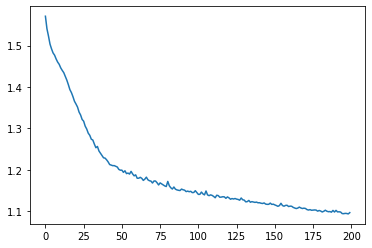

In [ ]:
import matplotlib.pyplot as plt

plt.plot(trainLoss, linestyle = 'solid')
# plt.plot(valLoss, linestyle = 'solid')
plt.show()

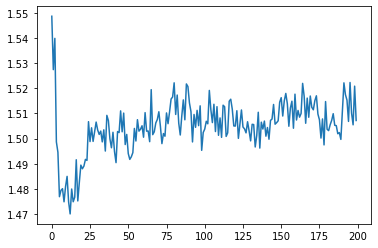

In [ ]:
plt.plot(valLoss, linestyle = 'solid')
plt.show()

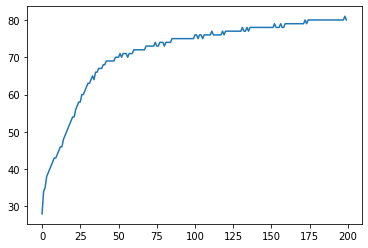

In [ ]:
k = trainAcc
k = [int(x*100) for x in k]
plt.plot(k, linestyle = 'solid')
plt.show()

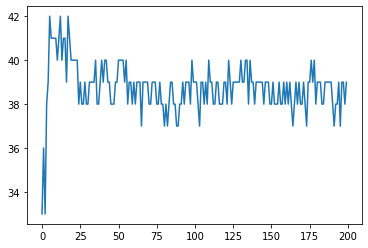

In [ ]:
k = valAcc
k = [int(x*100) for x in k]
plt.plot(k, linestyle = 'solid')
plt.show()

In [ ]:
next(iter(testDataset)).sentence

['effective', 'but', 'too', '-', 'tepid', 'biopic']

In [ ]:
testSamples = test[30:40]
testSamples.reset_index(inplace=True)
testSamples.head()


,index,labels,sentence
0,30,4,"a masterful film from a master filmmaker , uni..."
1,31,2,"light , cute and forgettable ."
2,32,3,if there 's a way to effectively teach kids ab...
3,33,3,while it would be easy to give crush the new t...
4,34,1,though everything might be literate and smart ...


In [ ]:


import spacy
nlp = spacy.load('en_core_web_sm')
testSamples.sentence = testSamples.sentence.apply(lambda x: x.lower() )



/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
testSamples.head()

,index,labels,sentence
0,30,4,"a masterful film from a master filmmaker , uni..."
1,31,2,"light , cute and forgettable ."
2,32,3,if there 's a way to effectively teach kids ab...
3,33,3,while it would be easy to give crush the new t...
4,34,1,though everything might be literate and smart ...


In [ ]:
testSamples['prediction'] = ''
testSamples['saliency'] = ''
model.eval()
# testSamples.reset_index(inplace=True)
for i in range(testSamples.shape[0]):
    tokenText = [word.text for word in nlp.tokenizer(testSamples.sentence[i])] 
    indexed = [sentence.vocab.stoi[t] for t in tokenText]             
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)       
    tensor = tensor.unsqueeze(1).T  
    length_tensor = torch.LongTensor(length)      
    prediction = model(tensor, length_tensor)
    prediction.sum().backward()
    _, pred = torch.max(prediction, 1) 
    # print( prediction.sum())
    # saliency,_ = torch.max(tensor.grad.data.abs(), dim=1)
    testSamples.prediction.loc[i] = pred.cpu().detach().numpy()[0]
    # testSamples.saliency.loc[i] = saliency

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [ ]:

testSamples[['labels','prediction','sentence']]
testSamples.to_csv("test.csv")

In [1]:
# model.train()
# model.embedding.requires_grad = True
# for i in range(1):
#     tokenText = [word.text for word in nlp.tokenizer(testSamples.sentence[i])] 
#     indexed = [sentence.vocab.stoi[t] for t in tokenText]             
#     length = [len(indexed)]
#     tensor2 = torch.Tensor(indexed).to(device)    
#     tensor2 = tensor2.unsqueeze(1).T  
    
#     tensor2.requires_grad = True
#     tensor2 = tensor2.long()
#     length_tensor = torch.LongTensor(length)      
    
#     prediction = model(tensor2, length_tensor)
#     # tensor.retain_grad()
#     prediction.sum().backward()
#     print(model.fc1.weight.grad)
#     print(model.embedding.weight.grad)
#     print(tensor2.grad)
#     # _, pred = torch.max(prediction, 1) 
#     # print( prediction.sum())
#     saliency,_ = torch.max(tensor2.grad.data.abs(), dim=1)
#     # testSamples.prediction.loc[i] = pred.cpu().detach().numpy()[0]
#     # testSamples.saliency.loc[i] = saliency

In [ ]:
sentence.vocab.stoi['stars']

943